In [1]:
%matplotlib inline
import matplotlib.pylab

In [2]:
import os
import mne
import glob
import matplotlib
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from pylab import savefig
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import pylab as pl

from IPython.display import display

from glob import glob

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from pandas import hashtable, tslib, lib
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/common.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas.algos as algos
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/index.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas.index as _index
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/tseries/frequencies.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas._period as period
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/sparse/array.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from pandas._sparse import BlockIndex, IntIndex


height has been deprecated.



/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/io/parsers.py:27: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas.parser as _parser
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/io/packers.py:63: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from pandas.msgpack import Unpacker as _Unpacker, Packer as _Packer


In [6]:
if ~os.path.isdir(roidir):
    os.system("sshfs ksitek@openmind7.mit.edu:/ ~/om -o defer_permissions -ocache=no")

In [3]:
work_dir = os.path.abspath('/Users/kevinsitek/om/om/scratch/Mon/ksitek/')
tracula_dir = os.path.abspath('/Users/kevinsitek/om/om/project/voice/processedData/tracula/')
probtrackx_dir = os.path.abspath('/Users/kevinsitek/om/om/project/voice/processedData/probtrackx')

#subject_list = ['voice999']
subject_list = [os.path.basename(x) for x in sorted(glob(tracula_dir+'/voice*'))]
print subject_list

['voice852', 'voice854', 'voice856', 'voice857', 'voice859', 'voice862', 'voice864', 'voice867', 'voice871', 'voice872', 'voice873', 'voice875', 'voice877', 'voice880', 'voice884', 'voice886', 'voice891', 'voice893', 'voice894', 'voice895', 'voice896', 'voice897', 'voice898', 'voice899', 'voice974', 'voice975', 'voice978', 'voice979', 'voice980', 'voice981', 'voice982', 'voice983', 'voice984', 'voice986', 'voice987', 'voice988', 'voice989', 'voice990', 'voice991', 'voice992', 'voice993', 'voice994', 'voice995', 'voice996', 'voice998', 'voice999']


**Import probtrackx results**

In [4]:
# normalize each subject's connectivity values by the total number of streamlines
def collapse_probtrack_results(waytotal_file, matrix_file):
    with open(waytotal_file) as f:
        waytotal = int(f.read())
    #data = nibabel.load(matrix_file).get_data()
    data = np.loadtxt(matrix_file)
    collapsed = data.sum(axis=0) / waytotal * 100.
    return collapsed

In [6]:
for sx, sub in enumerate(subject_list):    
    sub_dir = os.path.join(probtrackx_dir, sub)    
    matrix_file = os.path.join(sub_dir,'matrix1','_subject_id_%s'%sub,
                               'matrix_seeds_to_all_targets')    
    waytotal_file = os.path.join(sub_dir,'way_total',
                                 '_subject_id_%s'%sub, 'waytotal')
    if not sx:
        target_list_file = os.path.join(sub_dir, 'target_list',
                                       '_subject_id_%s'%sub,
                                       'target_masks.txt')    
        target_list_nii = np.genfromtxt(target_list_file, dtype='string')
        target_list = [s.replace('.nii','') for s in target_list_nii]
        #print target_list

        df = pd.DataFrame(columns=target_list, index=subject_list, dtype='float')
    
    df.loc[sub,:] = collapse_probtrack_results(waytotal_file, matrix_file)


['Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'wm-lh-bankssts', 'wm-lh-caudalanteriorcingulate', 'wm-lh-caudalmiddlefrontal', 'wm-lh-cuneus', 'wm-lh-entorhinal', 'wm-lh-fusiform', 'wm-lh-inferiorparietal', 'wm-lh-inferiortemporal', 'wm-lh-isthmuscingulate', 'wm-lh-lateraloccipital', 'wm-lh-lateralorbitofrontal', 'wm-lh-lingual', 'wm-lh-medialorbitofrontal', 'wm-lh-middletemporal', 'wm-lh-parahippocampal', 'wm-lh-paracentral', 'wm-lh-parsopercularis', 'wm-lh-parsorbitalis', 'wm-lh-parstriangularis', 'wm-lh-pericalcarine', 'wm-lh-postcentral', 'wm-lh-posteriorcingulate', 'wm-lh-precentral', 'wm-lh-

In [8]:
# split into subject groups (before other dataframe modifications - keep in mind)
data_mdd = df.loc[df.index.str.startswith('voice8')]
data_hc = df.loc[df.index.str.startswith('voice9')]

In [9]:
# add 'group' column with MDD = 1, HC = 0
df.loc[df.index.str.startswith('voice8'), 'group'] = 1
df.loc[df.index.str.startswith('voice9'), 'group'] = 0

df

,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,wm-rh-rostralmiddlefrontal,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group
voice852,0.000000,0.000000,0.000163,0.000041,0.000041,0.000000,0.009102,0.000041,0.000000,0.000041,...,1.873592,0.185592,0.659265,6.365388,4.925224,0.053510,2.661265,1.390041,100,1
voice854,0.000000,0.000000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,0.000000,0.001468,...,0.767143,0.102341,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1
voice856,0.000000,0.000000,0.000094,0.000142,0.000047,0.000047,0.000802,0.000000,0.000000,0.000000,...,0.750849,0.152170,0.480189,12.783255,3.906415,0.003396,4.913208,4.320236,100,1
voice857,0.000000,0.000000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,0.000000,0.000159,...,0.405476,0.073095,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1
voice859,0.000000,0.000040,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,0.000162,0.000040,...,0.146842,0.048745,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1
voice862,0.000000,0.000000,0.000244,0.003422,0.000041,0.000041,0.000122,0.000000,0.000000,0.002729,...,0.196619,0.305458,0.127780,10.912790,10.709328,0.005499,4.537963,2.040896,100,1
voice864,0.000000,0.000000,0.000418,0.003118,0.004259,0.003346,0.003916,0.000951,0.000038,0.009011,...,0.242319,0.004677,0.288137,9.915247,5.190570,0.001293,7.673080,2.627376,100,1
voice867,0.000000,0.000000,0.000000,0.000431,0.000000,0.000000,0.000000,0.000036,0.000000,0.000036,...,0.193860,0.047289,0.012567,7.545099,4.379102,0.005853,1.740682,1.686320,100,1
voice871,0.000000,0.000000,0.000000,0.002321,0.000045,0.000045,0.000357,0.000089,0.000000,0.000313,...,1.511875,0.032098,0.335134,10.881429,5.378259,0.150982,5.720759,2.893973,100,1
voice872,0.000000,0.000034,0.005119,0.004508,0.002441,0.003085,0.006237,0.000441,0.000136,0.000169,...,0.260983,0.004102,0.353661,11.811898,5.983085,0.000034,6.202475,1.111424,100,1


In [10]:
# add 'group-name' column
df.loc[df.index.str.startswith('voice8'), 'group-name'] = 'mdd'
df.loc[df.index.str.startswith('voice9'), 'group-name'] = 'hc'

df

,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group,group-name
voice852,0.000000,0.000000,0.000163,0.000041,0.000041,0.000000,0.009102,0.000041,0.000000,0.000041,...,0.185592,0.659265,6.365388,4.925224,0.053510,2.661265,1.390041,100,1,mdd
voice854,0.000000,0.000000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,0.000000,0.001468,...,0.102341,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1,mdd
voice856,0.000000,0.000000,0.000094,0.000142,0.000047,0.000047,0.000802,0.000000,0.000000,0.000000,...,0.152170,0.480189,12.783255,3.906415,0.003396,4.913208,4.320236,100,1,mdd
voice857,0.000000,0.000000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,0.000000,0.000159,...,0.073095,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1,mdd
voice859,0.000000,0.000040,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,0.000162,0.000040,...,0.048745,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1,mdd
voice862,0.000000,0.000000,0.000244,0.003422,0.000041,0.000041,0.000122,0.000000,0.000000,0.002729,...,0.305458,0.127780,10.912790,10.709328,0.005499,4.537963,2.040896,100,1,mdd
voice864,0.000000,0.000000,0.000418,0.003118,0.004259,0.003346,0.003916,0.000951,0.000038,0.009011,...,0.004677,0.288137,9.915247,5.190570,0.001293,7.673080,2.627376,100,1,mdd
voice867,0.000000,0.000000,0.000000,0.000431,0.000000,0.000000,0.000000,0.000036,0.000000,0.000036,...,0.047289,0.012567,7.545099,4.379102,0.005853,1.740682,1.686320,100,1,mdd
voice871,0.000000,0.000000,0.000000,0.002321,0.000045,0.000045,0.000357,0.000089,0.000000,0.000313,...,0.032098,0.335134,10.881429,5.378259,0.150982,5.720759,2.893973,100,1,mdd
voice872,0.000000,0.000034,0.005119,0.004508,0.002441,0.003085,0.006237,0.000441,0.000136,0.000169,...,0.004102,0.353661,11.811898,5.983085,0.000034,6.202475,1.111424,100,1,mdd


In [12]:
# reshape the data for easier plotting with seaborn
melter = pd.melt(df, id_vars=['group-name'], value_vars=df.columns.tolist()[:-2])

In [13]:
# check which connections actually exist
melter[melter['value'] > 0]

,group-name,variable,value
13,mdd,Left-Cerebellum-White-Matter,0.000038
18,mdd,Left-Cerebellum-White-Matter,0.000217
22,mdd,Left-Cerebellum-White-Matter,0.000040
27,hc,Left-Cerebellum-White-Matter,0.000323
28,hc,Left-Cerebellum-White-Matter,0.000040
34,hc,Left-Cerebellum-White-Matter,0.000086
44,hc,Left-Cerebellum-White-Matter,0.000081
50,mdd,Left-Cerebellum-Cortex,0.000040
55,mdd,Left-Cerebellum-Cortex,0.000034
59,mdd,Left-Cerebellum-Cortex,0.000038


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


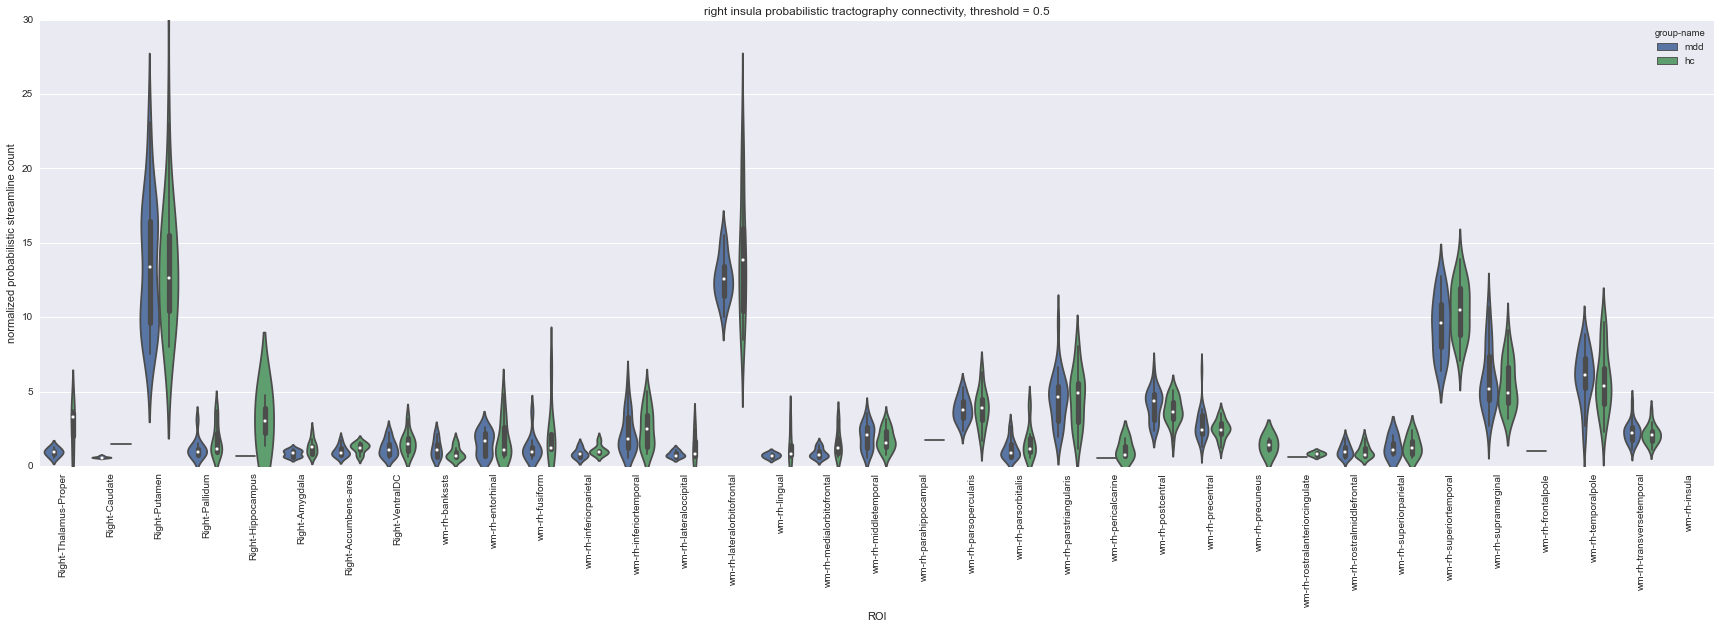

In [14]:
fig = plt.figure(figsize = (30,8));
thresh=.5;
g = sns.violinplot(x='variable',y='value',hue='group-name', 
                   jitter=True, data=melter[melter['value'] > thresh], fig=fig);
g.set(ylim=(0, 30), xlabel='ROI', ylabel='normalized probabilistic streamline count', 
      title='right insula probabilistic tractography connectivity, threshold = %.01f'%thresh);
plt.xticks(rotation=90);
#plt.savefig('plot.png');

### group difference statistics

In [15]:
# convert to array for simpler statistics computation
data_mdd_array = data_mdd.as_matrix() #
data_hc_array = data_hc.as_matrix()

In [17]:
roi_num = len(target_list)

t_mat = np.zeros(roi_num)
p_mat = np.zeros(roi_num)
mat = []

for r,roi in enumerate(target_list):
    t, p = scipy.stats.ranksums(data_mdd_array[:,r], data_hc_array[:,r])
    mat.append((t,p))
    
    if p < .10:
        print 'p = %.03f, t = %.02f - %s'%(p, t, roi)
    
    t_mat[r] = t
    p_mat[r] = p

p = 0.086, t = -1.72 - Brain-Stem
p = 0.053, t = -1.94 - Left-VentralDC
p = 0.022, t = -2.30 - Right-Cerebellum-White-Matter
p = 0.086, t = -1.72 - Right-Pallidum
p = 0.018, t = 2.37 - wm-rh-lateraloccipital
p = 0.095, t = -1.67 - wm-rh-medialorbitofrontal
p = 0.022, t = -2.29 - wm-rh-paracentral
p = 0.090, t = 1.69 - wm-rh-pericalcarine
p = 0.045, t = -2.00 - wm-rh-rostralanteriorcingulate
p = 0.068, t = -1.83 - wm-rh-superiortemporal


In [18]:
# FDR correction
from mne.stats import fdr_correction

reject, p_mat_fdr = fdr_correction(p_mat)

#print p_mat_nonan
print np.any(reject)
print reject
print np.min(p_mat_fdr)

False
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
0.65854988088


**behavioral correlations**

In [19]:
# import bdi scores
behav_dir = os.path.abspath('/Users/kevinsitek/Dropbox (MIT)/projects/voice_personal')
behav_file = os.path.join(behav_dir, '20160108_voicemaster.csv')
behav = pd.read_csv(behav_file)

In [66]:
# create and clean up a bdi dataframe
bdi_df = pd.DataFrame(behav.voice_id)
bdi_df = bdi_df.dropna()
bdi_df['voice_id'] = 'voice' + bdi_df['voice_id'].astype(int).astype(str)
bdi_df['bdi'] = behav.beckdepressionii_total
bdi_df.replace(['n/a'],['NaN'])

,voice_id,bdi
0,voice851,63
1,voice852,27
2,voice854,26
3,voice856,31
4,voice857,16
5,voice858,31
6,voice859,15
7,voice860,44
8,voice862,34
9,voice863,39


In [62]:
# merge the probtrackx dataframe with the bdi dataframe
merge_df = bdi_df.merge(df, right_index=True, left_on='voice_id')
merge_df.head()

,voice_id,bdi,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group,group-name
1,voice852,27,0,0.00000,0.000163,0.000041,0.000041,0.000000,0.009102,0.000041,...,0.185592,0.659265,6.365388,4.925224,0.053510,2.661265,1.390041,100,1,mdd
2,voice854,26,0,0.00000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,...,0.102341,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1,mdd
3,voice856,31,0,0.00000,0.000094,0.000142,0.000047,0.000047,0.000802,0.000000,...,0.152170,0.480189,12.783255,3.906415,0.003396,4.913208,4.320236,100,1,mdd
4,voice857,16,0,0.00000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,...,0.073095,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1,mdd
6,voice859,15,0,0.00004,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,...,0.048745,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1,mdd


In [77]:
# just look at MDD subjects
merge_df_mdd = merge_df.loc[merge_df.voice_id.str.startswith('voice8')]
merge_df_mdd.bdi = merge_df_mdd.bdi.astype(int)

mdd_bdi_mat = merge_df_mdd.as_matrix(columns=merge_df_mdd.columns[1:-2])
mdd_bdi_mat.shape

In [86]:
roi_num = len(target_list)

r_mat_bdi = np.zeros(roi_num)
p_mat_bdi = np.zeros(roi_num)
mat = []

for rx,roi in enumerate(target_list):
    r, p = scipy.stats.pearsonr(mdd_bdi_mat[:,0], mdd_bdi_mat[:,rx+1])
    r = np.arctanh(r)
    mat.append((r,p))
    
    if p < .10:
        print 'p = %.03f, r = %.02f - %s'%(p, r, roi)
    
    r_mat_bdi[rx] = t
    p_mat_bdi[rx] = p

p = 0.022, r = -0.52 - Right-Amygdala
p = 0.033, r = -0.48 - Right-VentralDC
p = 0.092, r = 0.38 - wm-lh-inferiorparietal
p = 0.090, r = 0.38 - wm-lh-parstriangularis
p = 0.055, r = 0.43 - wm-rh-bankssts
p = 0.090, r = 0.38 - wm-rh-caudalanteriorcingulate
p = 0.083, r = 0.39 - wm-rh-inferiorparietal
p = 0.075, r = -0.40 - wm-rh-paracentral
p = 0.049, r = 0.44 - wm-rh-supramarginal


In [87]:
# FDR correction
from mne.stats import fdr_correction

reject, p_mat_bdi_fdr = fdr_correction(p_mat_bdi)

#print p_mat_nonan
print np.any(reject)
print reject
print np.min(p_mat_bdi_fdr)

False
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
0.813755682383
